The goal of this notebook is to distill down the essential compenents of training HF models in a way that is easy to port to a data pipeline and apply to new model training scenarios.

# Imports

In [5]:
#from huggingface_hub import login
import os
import pandas as pd
from rich import print
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

pd.set_option('display.max_colwidth', None)

# Define variables

In [6]:
seed = 42 #reproducability  over training runs
clobber_project_dir = False #wipe the project director clean
project_dir = "chat_summarizer" #project name, also used as wandb project name

#creds
hf_token = os.environ["HF_TOKEN"]
wandb_key = os.environ["WANDB_KEY"]
hf_account_name = os.environ["HF_ACCOUNT_NAME"]

#HF touchpoints
hf_dataset_name = "knkarthick/dialogsum"
source_hf_model_name = "meta-llama/Llama-2-7b-hf"
destination_hf_model_name = f"{hf_account_name}/llama2-7b-dialogsum-qlora-gptq"
checkpoint_dir = "best_checkpoint"
quantization_dir = 'quantized_8bit'
merged_dir = 'merged_model'
quantized_train_dir = 'quant_trained_model'
project_path = os.path.join(project_dir, checkpoint_dir)
quant_path = os.path.join(project_dir, quantization_dir)
quantized_train_path = os.path.join(project_dir, quantized_train_dir)

train_test_split_ratio = 0.1

#LoRA hparams
lora_r = 64  # rank
lora_alpha = lora_r * 2
lora_dropout = 0.05

#training hparams
epochs = 2
per_device_train_batch_size=8
gradient_accumulation_steps=4
early_stopping_patience = 3
learning_rate = 3e-4
logging_steps = 25
device = "cuda"
max_training_sample_length = 2048

#quantization params
quantization_bits = 8

## State of working directory

In [7]:
print(project_dir)
!mkdir -p $project_dir

#Set clobber_project_dir to True to reset working directory
if clobber_project_dir:
    !rm -rf ./$project_dir

!ls -latrs ./$project_dir

chat_summarizer

total 0
0 drwxr-xr-x 1 root root 4096 Nov  5 04:48 runs
0 drwxr-xr-x 1 root root 4096 Nov  5 10:18 checkpoint-500
0 drwxr-xr-x 1 root root 4096 Nov  5 12:28 best_checkpoint
0 drwxr-xr-x 1 root root 4096 Nov  5 17:35 quantized
0 drwxr-xr-x 1 root root 4096 Nov  6 08:53 quantized_8bit
0 drwxr-xr-x 1 root root 4096 Nov  6 20:57 .
0 drwxr-xr-x 1 root root 4096 Nov  6 21:07 quant_trained_model
0 drwxr-xr-x 1 root root 4096 Nov  7 00:43 ..


## Initiate wandb

In [8]:
#import wandb

#wandb.login(key = wandb_key)
#run = wandb.init(project=project_dir, job_type="training", anonymous="allow")

# Process data for training

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import MaxNLocator



def generate(text, model, temp=0.7,max_new_tokens = 24):
    from transformers import TextStreamer
    streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=False)
    inputs = tokenizer(text, return_tensors="pt").to('cuda')

    # Call the generate method of the model with the given inputs and additional generation configurations.
    outputs = model.generate(**inputs,  # "inputs" likely includes input_ids or prompts for generation.
                           streamer=streamer,  # "streamer" not a standard parameter in HF documentation, likely custom for model-specific streaming.
                           max_new_tokens=max_new_tokens,  # Sets the maximum number of new tokens to generate; range varies based on model and computational limits.
                           temperature=temp,  # Controls randomness: lower->more deterministic, higher->more random; typically in range [0.5, 1.5].
                           do_sample=True,  # Enables sampling; when True, picks tokens based on probability distribution, rather than just most likely.
                           top_p=0.1,  # Nucleus sampling: selects top p% probability tokens for sampling; range [0, 1].
                           top_k=40,  # Top-k sampling: chooses from top k probability tokens; if k=0, it's the same as using no top-k.
                           repetition_penalty=1.23,  # Penalizes repeated tokens; >1 discourages, <1 encourages repetition; typically close to 1.
                           typical_p=1,  # Typical sampling; selects tokens whose cumulative probability is above this threshold, range [0, 1], usually close to 1.
                           guidance_scale=1,  # Affects the scale of guidance in models that support it, like CTRL; standard range not well-defined.
                           #seed=seed,  # Sets a seed for reproducibility; commented out, so not in use.
                          )
    generated_tokens = outputs[0].tolist()[len(inputs[0]):]
    result = tokenizer.decode(generated_tokens)
    return result

def set_plot_appearance(fontsize_title=14, 
                        fontsize_label=12, 
                        fontsize_ticks=8, 
                        theme='dark'):
    """
    Configure the plot's appearance with font sizes and theme for dark backgrounds.
    
    Parameters:
    fontsize_title: Font size for the title.
    fontsize_label: Font size for the x and y labels.
    fontsize_ticks: Font size for the x and y tick labels.
    theme: Seaborn theme for the plot's aesthetic style.
    """
    sns.set_theme(style=theme, palette='pastel')
    
    plt.rcParams.update({
        'figure.facecolor': '#1a1a1a',  # Very dark grey background for the figure
        'axes.facecolor': '#1a1a1a',    # Very dark grey background for the plots
        'grid.color': 'gray',           # Lighter grey grid lines (less contrast)
        'text.color': 'white',          # White text for better contrast on dark bg
        'axes.labelcolor': 'white',     # White labels for axes
        'xtick.color': 'white',         # White x-tick labels
        'ytick.color': 'white',         # White y-tick labels
        'axes.labelsize': fontsize_label,
        'axes.titlesize': fontsize_title,
        'xtick.labelsize': fontsize_ticks,
        'ytick.labelsize': fontsize_ticks,
        'legend.title_fontsize': fontsize_ticks + 2,
        'legend.fontsize': fontsize_ticks,
        'axes.edgecolor': 'lightgrey',  # Light grey color for the axes' spines
    })
# Possible modern themes: 'darkgrid', 'whitegrid', 'dark', 'white', and 'ticks'.
# Example usage: set_plot_appearance(theme='ticks')

def plot_text_length_histogram(df, bucket_size=64, percentile=95):
    """
    Plot a histogram of text lengths and indicate the percentile.

    Parameters:
    df: the pandas dataframe to render from
    bucket_size: the number of characters to bucket the histogram with
    percentile: draws a vertical line at this percentile to visualize whether an acceptable fraction of the data lenghts are being used for training set
    """
    set_plot_appearance()  # Apply appearance settings to the plot
    text_lengths = df['text'].apply(len)  # Calculate text lengths.
    bins = range(0, max(text_lengths) + bucket_size, bucket_size)  # Define histogram bins.
    percentile_value = np.percentile(text_lengths, percentile)  # Calculate percentile value.

    fig, ax = plt.subplots()  # Create figure and axis objects.
    ax.hist(text_lengths, bins=bins, edgecolor='black', alpha=0.7)  # Plot histogram.
    ax.axvline(x=percentile_value, color='red', linestyle='--')  # Draw percentile line.
    
    # Annotate the percentile line.
    ax.text(percentile_value, ax.get_ylim()[1]*0.9, f' {percentile}th Percentile: {int(round(percentile_value, -1))}',
            color='red', ha='left')

    ax.set_xlabel('Text Length')  # Set x-axis label.
    ax.set_ylabel('Frequency')  # Set y-axis label.
    ax.set_title('Histogram of Text Lengths')  # Set title.

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Set major locator for x-axis.
    plt.show()  # Display the plot.

def visualize_train_test_category_splits(train_df, test_df, top_x=5, normalize=True):
    """
    Visualize the frequency of top categories in training and test datasets.
    """
    set_plot_appearance()  # Apply appearance settings to the plot

    # Get top x categories from both datasets.
    train_topic_norm = train_df['topic'].value_counts(normalize=normalize).head(top_x)
    test_topic_norm = test_df['topic'].value_counts(normalize=normalize).head(top_x)
    
    # Prepare the data for plotting.
    train_topics = pd.DataFrame({'topic': train_topic_norm.index, 'frequency': train_topic_norm.values, 'dataset': 'Training'})
    test_topics = pd.DataFrame({'topic': test_topic_norm.index, 'frequency': test_topic_norm.values, 'dataset': 'Test'})
    combined_topics = pd.concat([train_topics, test_topics])

    sns.barplot(x='frequency', y='topic', hue='dataset', data=combined_topics)  # Create bar plot.
    plt.title('Top {} Topics Frequency Comparison'.format(top_x))  # Set title.
    plt.xlabel('Normalized Frequency')  # Set x-axis label.
    plt.ylabel('Topic')  # Set y-axis label.
    plt.tight_layout()  # Adjust layout.
    plt.show()  # Display the plot.



def get_data_stuff(dataset_name, split_ratio=0.2):    
    # %%
    from datasets import load_dataset
    from datasets import Dataset
    import pandas as pd
    pd.set_option('display.max_colwidth', None)
    
    
    #load the dataset
    dataset = load_dataset(dataset_name)
    
    # Shuffle the dataset (setting seed for reproducibility)
    shuffled_ds = dataset['train']#.shuffle(seed=seed)
    #shuffled_ds = shuffled_ds.select(range(1000))

    
    # Split the dataset into training and test sets with a test size of 20%
    train_test_split = shuffled_ds.train_test_split(test_size=train_test_split_ratio, seed = seed)
    
    # The train/test datasets are now accessible as follows:
    train_ds = train_test_split['train']
    raw_train_df = pd.DataFrame(train_ds)
    
    test_ds = train_test_split['test']
    raw_test_df = pd.DataFrame(test_ds)
    
    prepared_train_df = prepare_dataset(raw_train_df, "train")
    prepared_test_df = prepare_dataset(raw_test_df, "test")

    prepared_train_dataset = Dataset.from_pandas(prepared_train_df)
    prepared_test_dataset = Dataset.from_pandas(prepared_test_df)
    
    print(f"length of downloaded ds: {len(shuffled_ds)}")
    print(f"length of train_ds: {len(prepared_train_dataset)}")
    print(f"length of test_ds: {len(prepared_test_dataset)}")
    estimated_training_steps = epochs * len(prepared_train_dataset) / per_device_train_batch_size / gradient_accumulation_steps
    print(f"estimated training steps will be {estimated_training_steps}")
    return prepared_train_df, prepared_test_df, prepared_train_dataset, prepared_test_dataset


def prepare_dataset(df, split="train"):
    text_col = []
    instruction = """Write a concise summary of the below input text.Ensure that responses covers the key points of the text.Only provide full sentence responses."""  # change instuction according to the task
    if split == "train":
        for _, row in df.iterrows():
            input_q = row["dialogue"]
            output = row["summary"]
            text = (
                "### Instruction: \n"
                + instruction
                + "\n### Input: \n"
                + input_q
                + "\n### Response :\n"
                + output
                + "\n### End"
            )  # keeping output column in training dataset
            text_col.append(text)
        df.loc[:, "text"] = text_col
    else:
        for _, row in df.iterrows():
            input_q = row["dialogue"]
            text = (
                "### Instruction: \n"
                + instruction
                + "\n### Input: \n"
                + input_q
                + "\n### Response :\n"
            )  # not keeping output column in test dataset
            text_col.append(text)
        df.loc[:, "text"] = text_col
    return df



In [10]:
train_df, test_df, train_dataset, test_dataset = get_data_stuff(hf_dataset_name, 
                                                                split_ratio=train_test_split_ratio,
                                                               )
text = test_df['text'][1]

length of downloaded ds: 12460

length of train_ds: 11214

length of test_ds: 1246

estimated training steps will be 700.875

In [11]:
print(text)

### Instruction: 
Write a concise summary of the below input text.Ensure that responses covers the key points of the text.Only 
provide full sentence responses.
### Input: 
#Person1#: Mister Ewing said we should show up at the conference center at 4:00 o'clock, right?
#Person2#: Yes, he especially asked us not to be late. Some of the people from our east york branch office are 
coming, and he wants to make a good impression on them. How are you getting there?
#Person1#: I was thinking of taking my car, but I think I'm just going to take the underground, because there is 
construction on the highway. What about you?
#Person2#: I'll be taking the underground as well. Why don't we go together? I've been to the conference center 
only once, and I'm not sure if I can find my way around there.
### Response :

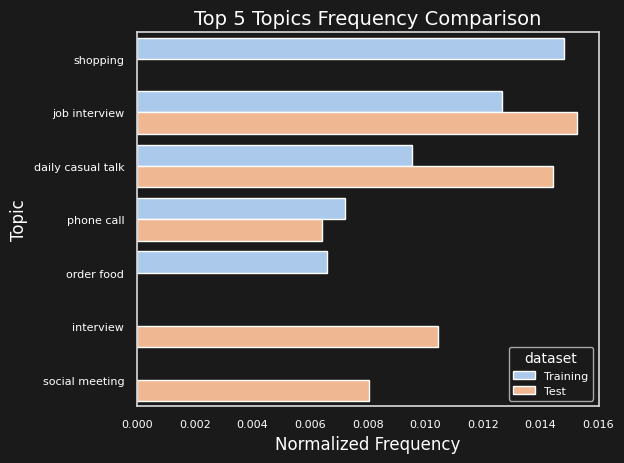

In [12]:
#to enhance training, consider rolling the shuffle dice until you get good consistency between training and test set categories.
visualize_train_test_category_splits(train_df, test_df, top_x=5, normalize=True)

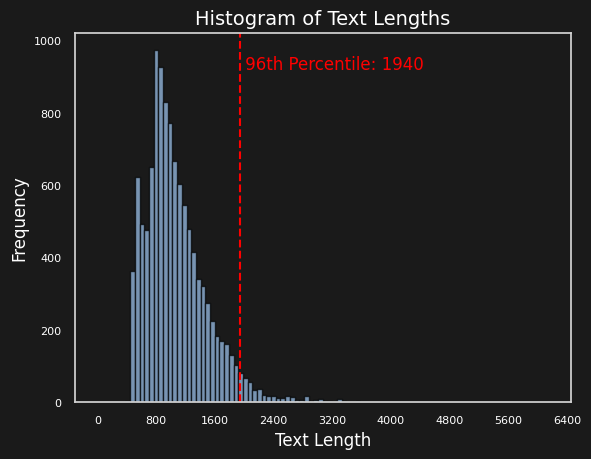

In [13]:
#this just measures space-delimited words which isn't necessarily the same as toke count, but it should be close-ish
plot_text_length_histogram(train_df, percentile = 96)

## Load source model/tokenizer

In [12]:
%%time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

# Quantization config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype="float16",
)

# loading the model with quantization config
model = AutoModelForCausalLM.from_pretrained(
    source_hf_model_name,
    quantization_config=bnb_config,
    trust_remote_code=True,
    device_map="auto",
    token = hf_token,
)

model.config.use_cache = True  #surpress the download and use cache. # apparently needed because of https://github.com/huggingface/transformers/pull/24906
model.config.pretraining_tp = 1  #disable tensor parallelism
#print(model)

#fixme
tokenizer = AutoTokenizer.from_pretrained(
    source_hf_model_name, 
    trust_remote_code=True, 
    return_token_type_ids=False,
    token = hf_token,
)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/app/venv/lib/python3.10/site-packages/transformers/utils/hub.py:374: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


CPU times: user 5.93 s, sys: 31.7 s, total: 37.6 s
Wall time: 3min 21s


In [13]:
%%time
import trl
from peft import LoraConfig, get_peft_model
from peft import prepare_model_for_kbit_training
from trl import SFTTrainer
from transformers import EarlyStoppingCallback
import transformers



# Parameter efficient finetuning for LoRA configuration

peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    #target_modules=[ "q_proj","v_proj",],  # we will only create adopters for q, v metrices of attention module
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj","gate_proj"],
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)


training_arguments = transformers.TrainingArguments(
    output_dir=project_dir,
    #load_from_checkpoint=str,
    seed = seed,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim="paged_adamw_8bit",
    learning_rate= learning_rate,
    #lr_scheduler_type="linear",
    save_strategy="steps",
    logging_steps=logging_steps,
    num_train_epochs=epochs,
    max_steps=0,
    fp16=True,
    push_to_hub=False,
    evaluation_strategy="steps",  # Add this line
    eval_steps=logging_steps,  # Add this line
    metric_for_best_model="loss",
    greater_is_better=False,
    load_best_model_at_end=True,
)
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    peft_config=peft_config,  # passing peft config
    dataset_text_field="text",  # mentioned the required column
    args=training_arguments,  # training agruments
    tokenizer=tokenizer,  # tokenizer
    packing=False,
    max_seq_length=max_training_sample_length,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=early_stopping_patience)],
)

Map:   0%|          | 0/11214 [00:00<?, ? examples/s]

Map:   0%|          | 0/1246 [00:00<?, ? examples/s]

CPU times: user 28.4 s, sys: 1.77 s, total: 30.2 s
Wall time: 21.1 s


## Train lora

In [ ]:
%%time
if False:
    trainer.train()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss,Validation Loss
25,1.209800,1.187238
50,1.138500,1.176472
75,1.110000,1.170948
100,1.124200,1.163659
125,1.098700,1.159371
150,1.099800,1.155005
175,1.107700,1.150710
200,1.070700,1.145581
225,1.077100,1.140861
250,1.078300,1.136599


In [22]:
print("done!")

done!

## save peft model

In [13]:
%%time
import os
trainer.model.save_pretrained(project_path)

NameError: name 'trainer' is not defined

In [15]:
project_dir

'chat_summarizer'

In [17]:
!ls -lhatrs ./$project_path/

total 375M
   0 drwxr-xr-x 1 root root 4.0K Nov  5 12:28 .
   0 drwxr-xr-x 1 root root 4.0K Nov  5 17:35 ..
4.0K -rw-r--r-- 1 root root 1.3K Nov  5 18:26 README.md
375M -rw-r--r-- 1 root root 375M Nov  5 18:26 adapter_model.bin
   0 -rw-r--r-- 1 root root  493 Nov  5 18:26 adapter_config.json


In [18]:
!ls -latrsh ./$project_path

total 375M
   0 drwxr-xr-x 1 root root 4.0K Nov  5 12:28 .
   0 drwxr-xr-x 1 root root 4.0K Nov  5 17:35 ..
4.0K -rw-r--r-- 1 root root 1.3K Nov  5 18:26 README.md
375M -rw-r--r-- 1 root root 375M Nov  5 18:26 adapter_model.bin
   0 -rw-r--r-- 1 root root  493 Nov  5 18:26 adapter_config.json


In [19]:
!cat ./$project_path/README.md


---
library_name: peft
---
## Training procedure


The following `bitsandbytes` quantization config was used during training:
- quant_method: bitsandbytes
- load_in_8bit: False
- load_in_4bit: True
- llm_int8_threshold: 6.0
- llm_int8_skip_modules: None
- llm_int8_enable_fp32_cpu_offload: False
- llm_int8_has_fp16_weight: False
- bnb_4bit_quant_type: nf4
- bnb_4bit_use_double_quant: False
- bnb_4bit_compute_dtype: float16

The following `bitsandbytes` quantization config was used during training:
- quant_method: bitsandbytes
- load_in_8bit: False
- load_in_4bit: True
- llm_int8_threshold: 6.0
- llm_int8_skip_modules: None
- llm_int8_enable_fp32_cpu_offload: False
- llm_int8_has_fp16_weight: False
- bnb_4bit_quant_type: nf4
- bnb_4bit_use_double_quant: False
- bnb_4bit_compute_dtype: float16

The following `bitsandbytes` quantization config was used during training:
- quant_method: bitsandbytes
- load_in_8bit: False
- load_in_4bit: True
- llm_int8_threshold: 6.0
- llm_int8_skip_modules:

## Load peft model from checkpoint on disk

In [20]:
from peft import LoraConfig, get_peft_model
lora_config = LoraConfig.from_pretrained(project_path)
lmodel = get_peft_model(model, lora_config)

NameError: name 'model' is not defined

In [83]:
#text = test_df['text'][500]
print(text)
result = generate(text, lmodel, max_new_tokens=64, temp=0.1)
#del lmodel

### Instruction: 
Write a concise summary of the below input text.Ensure that responses covers the key points of the text.Only 
provide full sentence responses.
### Input: 
#Person1#: Well, Charles, I must say that your shop is pretty remarkable. Do people send the fax messages abroad, 
or is it just to this country?
#Person2#: It's surprising because when I started, I thought I'd be sending things to London and maybe Birmingham 
but, in fact, a high percentage of it is sent abroad, because it's immediate and speedy.
#Person1#: And how much would it cost, for example, if I wanted to send a fax to the United States?
#Person2#: Well, a fax to the United States would cost you five pounds for a page. And when you think that in 
England by the Royal Mail, it would cost you twelve pounds to send a page by special delivery, it's actually a good
value.
#Person1#: Ok. What about your hours? How long do you have to spend actually in the shop?
#Person2#: Well, the shop is open from eight in the morning until six at night, six days a week, and then a sort of
fairly flexible morning on a Sunday. Urn, and of those hours, I'm in it quite a lot.
#Person1#: And did you enjoy it?
#Person2#: Yes, overall I enjoy it. Running a business by yourself is hard work and you never quite like every 
aspect all the time. 95% of the customers I love. Uh, 2% I really, you know, I'm not too bothered about. And 3% I 
positively hate.
#Person1#: What, what's the problem with those?
#Person2#: Um, it's hard to categorize really. I find people who are just totally rude, um, unnecessary, and I 
don't really need their business and I suppose they form the volume of the people that I don't like but it's a very
small percentage.
### Response :

The above conversation between two persons named Person1 and Person2 took place in an office where both were working as employees. The first person was interested in knowing more details regarding the services provided by his colleague’s company which he had heard recently. He asked him whether there were any other countries apart from UK whose citizens


In [92]:
#del  model

In [85]:
result

'The above conversation between two persons named Person1 and Person2 took place in an office where both were working as employees. The first person was interested in knowing more details regarding the services provided by his colleague’s company which he had heard recently. He asked him whether there were any other countries apart from UK whose citizens'

## load the orignal mode

In [11]:
project_path

'chat_summarizer/best_checkpoint'

In [15]:
%%time
from peft import AutoPeftModelForCausalLM
from transformers import  AutoTokenizer

# tokenizer = AutoTokenizer.from_pretrained(
#     source_hf_model_name, 
#     trust_remote_code=True, 
#     return_token_type_ids=False,
#     token = hf_token,
# )
tokenizer = AutoTokenizer.from_pretrained(source_hf_model_name)
persisted_model = AutoPeftModelForCausalLM.from_pretrained(
    project_path,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map=device,
    token=hf_token,
)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/app/venv/lib/python3.10/site-packages/transformers/utils/hub.py:374: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


CPU times: user 46.8 s, sys: 27.9 s, total: 1min 14s
Wall time: 5min 58s


In [18]:
#text = test_df['text'][500]
print(text)
result = generate(text, persisted_model, max_new_tokens=64, temp=0.1)
#del persisted_model

### Instruction: 
Write a concise summary of the below input text.Ensure that responses covers the key points of the text.Only 
provide full sentence responses.
### Input: 
#Person1#: Mister Ewing said we should show up at the conference center at 4:00 o'clock, right?
#Person2#: Yes, he especially asked us not to be late. Some of the people from our east york branch office are 
coming, and he wants to make a good impression on them. How are you getting there?
#Person1#: I was thinking of taking my car, but I think I'm just going to take the underground, because there is 
construction on the highway. What about you?
#Person2#: I'll be taking the underground as well. Why don't we go together? I've been to the conference center 
only once, and I'm not sure if I can find my way around there.
### Response :

The meeting will start at four in the afternoon according to Mr. Ewing who has requested for everyone to arrive early so they do not miss out anything important during the event. He also mentioned that some members from their East York Branch Office would attend this meeting which means it’s very crucial since these individuals have never


In [28]:
result

'Driving is no longer considered as one of the best ways for travelers who want to explore China in depth because there are many other options available nowadays such as taking trains or planes which can save both money & time compared with cars especially when going from Beijing (the capital city) all over'

In [19]:
del persisted_model

## Merge the lora and original model

In [20]:
merged_dir
!ls -lathrs $merged_dir

total 13G
   0 -rw-r--r-- 1 root root   42 Nov  5 15:59 added_tokens.json
   0 drwxr-xr-x 1 root root 4.0K Nov  5 15:59 .
4.0K -rw-r--r-- 1 root root  656 Nov  5 21:28 config.json
   0 -rw-r--r-- 1 root root  183 Nov  5 21:28 generation_config.json
9.3G -rw-r--r-- 1 root root 9.3G Nov  5 21:35 model-00001-of-00002.safetensors
3.3G -rw-r--r-- 1 root root 3.3G Nov  5 21:35 model-00002-of-00002.safetensors
 24K -rw-r--r-- 1 root root  24K Nov  5 21:35 model.safetensors.index.json
4.0K -rw-r--r-- 1 root root  900 Nov  5 21:35 tokenizer_config.json
   0 -rw-r--r-- 1 root root  414 Nov  5 21:35 special_tokens_map.json
492K -rw-r--r-- 1 root root 489K Nov  5 21:35 tokenizer.model
1.8M -rw-r--r-- 1 root root 1.8M Nov  5 21:35 tokenizer.json
   0 drwxr-xr-x 1 root root 4.0K Nov  6 06:33 ..


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [30]:
%%time


merged_model = persisted_model.merge_and_unload(progressbar=True)

merged_model.save_pretrained(merged_dir, safe_serialization=True)
tokenizer.save_pretrained(merged_dir)

del persisted_model

Unloading and merging model: 100%|██████████| 454/454 [00:18<00:00, 25.05it/s]


CPU times: user 6min 51s, sys: 5.47 s, total: 6min 57s
Wall time: 7min 4s


## Load merged model from disk

In [21]:
%%time
tokenizer = AutoTokenizer.from_pretrained(merged_dir)
merged_model_from_disk = AutoModelForCausalLM.from_pretrained( merged_dir, device_map=device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 20.3 s, sys: 2min 39s, total: 2min 59s
Wall time: 1min 43s


In [23]:
print(text)
result = generate(text, merged_model_from_disk,max_new_tokens=64, temp = 0.01)

### Instruction: 
Write a concise summary of the below input text.Ensure that responses covers the key points of the text.Only 
provide full sentence responses.
### Input: 
#Person1#: Mister Ewing said we should show up at the conference center at 4:00 o'clock, right?
#Person2#: Yes, he especially asked us not to be late. Some of the people from our east york branch office are 
coming, and he wants to make a good impression on them. How are you getting there?
#Person1#: I was thinking of taking my car, but I think I'm just going to take the underground, because there is 
construction on the highway. What about you?
#Person2#: I'll be taking the underground as well. Why don't we go together? I've been to the conference center 
only once, and I'm not sure if I can find my way around there.
### Response :

The meeting will start at four in the afternoon according to Mr. Ewing who has requested for everyone to arrive early so they do not miss out anything important during the event. He also mentioned that some members from their East York Branch Office would attend this meeting which means it’s very crucial since these individuals have never


In [21]:
#del merged_model_from_disk

## Quantize it

In [24]:
merged_dir

'merged_model'

In [25]:
%%time
from transformers import GPTQConfig

quantization_config = GPTQConfig(
    bits=quantization_bits,
    dataset=["c4"],
    desc_act=False,
)

quant_model = AutoModelForCausalLM.from_pretrained(
    merged_dir, 
    quantization_config=quantization_config, 
    device_map=device
)
tokenizer = AutoTokenizer.from_pretrained(merged_dir)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Quantizing model.layers blocks :   0%|          | 0/32 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

CPU times: user 1h 47min 34s, sys: 15min 59s, total: 2h 3min 34s
Wall time: 1h 46min 54s


In [32]:
#del persisted_model

## Save quantized model to disk

In [27]:
quant_path

'chat_summarizer/quantized_8bit'

In [28]:
%%time

quant_path = os.path.join(project_dir, quantization_dir)
print(f"saving to {quant_path}")

# Save the quantized model
quant_model.save_pretrained(quant_path, safe_serialization=True)
tokenizer.save_pretrained(quant_path)
#del persisted_model

saving to chat_summarizer/quantized_8bit

CPU times: user 2.3 s, sys: 1.84 s, total: 4.13 s
Wall time: 9.19 s


('chat_summarizer/quantized_8bit/tokenizer_config.json',
 'chat_summarizer/quantized_8bit/special_tokens_map.json',
 'chat_summarizer/quantized_8bit/tokenizer.model',
 'chat_summarizer/quantized_8bit/added_tokens.json',
 'chat_summarizer/quantized_8bit/tokenizer.json')

In [30]:
print(quant_path)
!ls -latrsh $quant_path

chat_summarizer/quantized_8bit

total 6.7G
   0 drwxr-xr-x 1 root root 4.0K Nov  6 08:53 ..
4.0K -rw-r--r-- 1 root root 1.2K Nov  6 08:53 config.json
   0 -rw-r--r-- 1 root root  183 Nov  6 08:53 generation_config.json
6.7G -rw-r--r-- 1 root root 6.7G Nov  6 08:53 model.safetensors
4.0K -rw-r--r-- 1 root root  900 Nov  6 08:53 tokenizer_config.json
   0 -rw-r--r-- 1 root root  414 Nov  6 08:53 special_tokens_map.json
492K -rw-r--r-- 1 root root 489K Nov  6 08:53 tokenizer.model
   0 drwxr-xr-x 1 root root 4.0K Nov  6 08:53 .
1.8M -rw-r--r-- 1 root root 1.8M Nov  6 08:53 tokenizer.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Load quantized model from disk

In [33]:
from transformers import AutoModelForCausalLM, AutoTokenizer

print(quant_path)
quant_model_from_disk = AutoModelForCausalLM.from_pretrained( quant_path, device_map=device)
tokenizer = AutoTokenizer.from_pretrained(quant_path)

chat_summarizer/quantized_8bit

In [34]:
print(text,"\n","="*30)
result = generate(text, quant_model_from_disk,max_new_tokens=64, temp = 0.1)

### Instruction: 
Write a concise summary of the below input text.Ensure that responses covers the key points of the text.Only 
provide full sentence responses.
### Input: 
#Person1#: Mister Ewing said we should show up at the conference center at 4:00 o'clock, right?
#Person2#: Yes, he especially asked us not to be late. Some of the people from our east york branch office are 
coming, and he wants to make a good impression on them. How are you getting there?
#Person1#: I was thinking of taking my car, but I think I'm just going to take the underground, because there is 
construction on the highway. What about you?
#Person2#: I'll be taking the underground as well. Why don't we go together? I've been to the conference center 
only once, and I'm not sure if I can find my way around there.
### Response :
 
 ==============================

The meeting will start at four in the afternoon according to Mr. Ewing who has requested for everyone to arrive early so they do not miss out anything important during the event. He also mentioned that some members from their East York Branch Office would attend this meeting which means it’s very crucial since these individuals have never


In [29]:
result

'I think this is one of those times when we should be thankful for what we already have and stop trying to get more stuff. We don’t need any new clothes or accessories; our wardrobes are filled up as they can possibly be without looking like we just stepped out of some thrift store'

## Push model to HuggingFace hub

In [35]:
%%time

tokenizer.push_to_hub(destination_hf_model_name, token=hf_token)
quant_model_from_disk.push_to_hub(destination_hf_model_name, token = hf_token)

pytorch_model.bin:   0%|          | 0.00/7.16G [00:00<?, ?B/s]

CPU times: user 27 s, sys: 7.34 s, total: 34.3 s
Wall time: 4min 43s


CommitInfo(commit_url='https://huggingface.co/andersonjas/llama2-7b-dialogsum-qlora-gptq/commit/4e4225ff8fe753c5211bd62c00a23f0dfba561c7', commit_message='Upload LlamaForCausalLM', commit_description='', oid='4e4225ff8fe753c5211bd62c00a23f0dfba561c7', pr_url=None, pr_revision=None, pr_num=None)

In [28]:
%%time
# %%
#from transformers import GPTQConfig

# quantization_config = GPTQConfig(
#     bits=4,
#     dataset=["c4"],
#     desc_act=False,
# )
#quantization_config_loading = GPTQConfig(bits=4, disable_exllama=True)
from_disk_quant_model = AutoModelForCausalLM.from_pretrained(
    destination_hf_model_name, 
    #quantization_config=quantization_config_loading, 
    device_map=device,
)
tokenizer = AutoTokenizer.from_pretrained(destination_hf_model_name)

CPU times: user 9.2 s, sys: 5.29 s, total: 14.5 s
Wall time: 16.6 s


## Test the model by pulling from hugging face hub

In [33]:
#text = test_df['text'][500]
text = test_df['text'][4]
print(text)
result = generate(text, from_disk_quant_model, max_new_tokens=85,temp=1)

### Instruction: 
Write a concise summary of the below input text.Ensure that responses covers the key points of the text.Only 
provide full sentence responses.
### Input: 
#Person1#: Mr. James. I know that office hour is up now, but could you work during the weekend and finish the 
translations?
#Person2#: Well, unfortunately I have got something to do this weekend. But let me see...
#Person1#: Oh, I'm sorry. However, if you could help me out, I'll double the pay for the hours worked.
#Person2#: That's very kind of you. How soon do you really need them?
#Person1#: I'll need them for the conference on Monday afternoon. Do you think it can be done by then?
#Person2#: I'll try.
#Person1#: Thank you very much, Mr. James.
### Response :

Mr.James knows that he has an important meeting coming in next few days so he needs some extra hands from his colleague. He asks him whether he would like to join him over the weekends as well because there are many documents which still require translation. His friend agrees with him and says that he will definitely come forward to support him. They both discuss about how they should proceed further. Finally after having discussion ,


In [22]:
result

'The above conversation took place during an informal meeting among two golf players who met each other by chance and decided to go out for a round of golf after their respective games ended. The first player (Jane) had recently moved into town from another state where she played regularly. She has been looking forward to joining her new community’s country club since moving there several months ago; however, due to lack of funds or interest in becoming involved with its activities until now when she finally found someone willing enough to take up golf as his hobby again despite having no prior experience whatsoever beforehand either through trial-and-error'

# Train a GPTQ model

In [10]:
from datasets import Dataset
dataset = Dataset.from_pandas(train_df)
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import prepare_model_for_kbit_training
from transformers import GPTQConfig

model_id = "TheBloke/Llama-2-7B-GPTQ"

quantization_config_loading = GPTQConfig(bits=4, disable_exllama=True)
model = AutoModelForCausalLM.from_pretrained(
                              model_id,
                              quantization_config=quantization_config_loading,
                              device_map="auto"
                          )
tokenizer = AutoTokenizer.from_pretrained(model_id)
model.config.use_cache = False
# https://github.com/huggingface/transformers/pull/24906
#disable tensor parallelism
model.config.pretraining_tp = 1

You passed `quantization_config` to `from_pretrained` but the model you're loading already has a `quantization_config` attribute and has already quantized weights. However, loading attributes (e.g. disable_exllama, use_cuda_fp16, max_input_length) will be overwritten with the one you passed to `from_pretrained`. The rest will be ignored.


In [11]:
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)
from peft import LoraConfig, get_peft_model
config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["k_proj","o_proj","q_proj","v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)

In [14]:
import transformers
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

args=transformers.TrainingArguments(
        per_device_train_batch_size=1,
        gradient_accumulation_steps=1,
        warmup_steps=2,
        max_steps=300,
        learning_rate=2e-4,
        fp16=True, #use mixed precision training
        logging_steps=1,
        output_dir=quantized_train_path,
        optim="adamw_hf",
        save_strategy="epoch")

from trl import SFTTrainer
trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=dataset,
    peft_config=config,
    dataset_text_field="text",
    tokenizer=tokenizer,
    packing=False,
    max_seq_length=512)

trainer.train()

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f6cef91cfa0>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7f6cdd9bfe80, raw_cell="import transformers
tokenizer.pad_token = tokenize.." store_history=True silent=False shell_futures=True cell_id=96e00d1c-04e2-4af5-aeb2-f40762898ccc>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

Map:   0%|          | 0/11214 [00:00<?, ? examples/s]

Step,Training Loss
1,1.423000
2,1.193400
3,1.259900
4,1.041900
5,0.984800
6,1.214300
7,1.184400
8,1.112500
9,1.114100
10,0.749300


TrainOutput(global_step=300, training_loss=1.1282121592760086, metrics={'train_runtime': 174.8732, 'train_samples_per_second': 1.716, 'train_steps_per_second': 1.716, 'total_flos': 78501617197056.0, 'train_loss': 1.1282121592760086, 'epoch': 0.03})

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f6cef91cfa0>> (for post_run_cell), with arguments args (<ExecutionResult object at 7f6cdd9bfcd0, execution_count=14 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f6cdd9bfe80, raw_cell="import transformers
tokenizer.pad_token = tokenize.." store_history=True silent=False shell_futures=True cell_id=96e00d1c-04e2-4af5-aeb2-f40762898ccc> result=TrainOutput(global_step=300, training_loss=1.1282121592760086, metrics={'train_runtime': 174.8732, 'train_samples_per_second': 1.716, 'train_steps_per_second': 1.716, 'total_flos': 78501617197056.0, 'train_loss': 1.1282121592760086, 'epoch': 0.03})>,),kwargs {}:


TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

In [17]:
!ls -latrsh $quantized_train_path/checkpoint-300

total 99M
   0 drwxr-xr-x 1 root root 4.0K Nov  6 21:07 ..
   0 drwxr-xr-x 1 root root 4.0K Nov  6 21:07 .
4.0K -rw-r--r-- 1 root root  819 Nov  7 00:03 tokenizer_config.json
   0 -rw-r--r-- 1 root root  434 Nov  7 00:03 special_tokens_map.json
492K -rw-r--r-- 1 root root 489K Nov  7 00:03 tokenizer.model
1.8M -rw-r--r-- 1 root root 1.8M Nov  7 00:03 tokenizer.json
8.0K -rw-r--r-- 1 root root 4.5K Nov  7 00:03 training_args.bin
 65M -rw-r--r-- 1 root root  65M Nov  7 00:03 optimizer.pt
4.0K -rw-r--r-- 1 root root 1.1K Nov  7 00:03 scheduler.pt
 36K -rw-r--r-- 1 root root  36K Nov  7 00:03 trainer_state.json
 16K -rw-r--r-- 1 root root  14K Nov  7 00:03 rng_state.pth
4.0K -rw-r--r-- 1 root root 2.8K Nov  7 00:03 README.md
 33M -rw-r--r-- 1 root root  33M Nov  7 00:03 adapter_model.bin
   0 -rw-r--r-- 1 root root  474 Nov  7 00:03 adapter_config.json


In [21]:
from peft import AutoPeftModelForCausalLM
from time import perf_counter
from rich import print
from transformers import GenerationConfig
model_id = "TheBloke/Llama-2-7B-GPTQ"
# To perform inference on the test dataset example load the model from the checkpoint
tokenizer = AutoTokenizer.from_pretrained(model_id)

persisted_model = AutoPeftModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path=quantized_train_path + "/checkpoint-300",
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map="auto")
# Some gen config knobs
generation_config = GenerationConfig(
    penalty_alpha=0.6, 
    do_sample = True, 
    top_k=5, 
    temperature=0.5, 
    repetition_penalty=1.2,
    max_new_tokens=100
)
start_time = perf_counter()
outputs = persisted_model.generate(**inputs, generation_config=generation_config)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))
end_time = perf_counter()
output_time = end_time - start_time
print(f"Time taken for inference: {round(output_time,2)} seconds")

KeyboardInterrupt: 

In [26]:
2#text = test_df['text'][500]
text = test_df['text'][1]
print(text)
result = generate(text, persisted_model, max_new_tokens=185,temp=.001)

### Instruction: 
Write a concise summary of the below input text.Ensure that responses covers the key points of the text.Only 
provide full sentence responses.
### Input: 
#Person1#: Mister Ewing said we should show up at the conference center at 4:00 o'clock, right?
#Person2#: Yes, he especially asked us not to be late. Some of the people from our east york branch office are 
coming, and he wants to make a good impression on them. How are you getting there?
#Person1#: I was thinking of taking my car, but I think I'm just going to take the underground, because there is 
construction on the highway. What about you?
#Person2#: I'll be taking the underground as well. Why don't we go together? I've been to the conference center 
only once, and I'm not sure if I can find my way around there.
### Response :

Ms. #Person1# asks Mr. #Person2# how they will get to the conference center for their meeting with mr. ewing. They decide to travel by subway since it takes longer time than usual due to road constructions.
### End:
</s>
